# Initial training

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time

start = time.time()


path = 'smoke_detection_iot.csv'

data = pd.read_csv(path).drop(['Unnamed: 0', 'UTC', 'CNT'], axis=1)
Y_df = data['Fire Alarm']
X_df = data.drop('Fire Alarm', axis=1)

Y_test_raw = X_df.values
Y_raw = Y_df.values

X_train_raw, X_test_raw, Y_train_raw, Y_test_raw = train_test_split(Y_test_raw, Y_raw, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_raw = scaler.fit_transform(X_train_raw)
X_test_raw = scaler.transform(X_test_raw)

----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.7036049366 | 0.6647215486 |
----------------------------------------
|   500 |  0.0036830583 | 0.0034992695 |
----------------------------------------
|  1000 |  0.0021918381 | 0.0021612872 |
----------------------------------------
|  1500 |  0.0011886482 | 0.0013150900 |
----------------------------------------
|  2000 |  0.0006887493 | 0.0008333132 |
----------------------------------------
|  2500 |  0.0004243401 | 0.0008670712 |
----------------------------------------
|  2999 |  0.0002902900 | 0.0005160521 |
----------------------------------------
Accuracy: 0.9998403321092129
Precision: 1.0
Recall: 0.9997758098867839
F1: 0.9998878923766816
Confusion_matrix:
[[3605    0]
 [   2 8919]]
Classification_report:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3605
         1.0       1.00      1.0

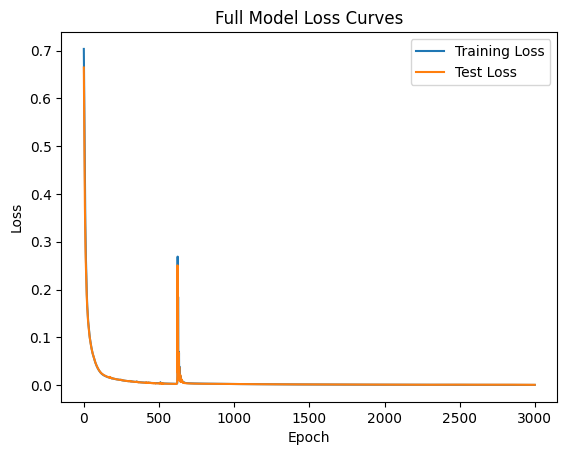

In [2]:
from alarmnetclass import AlarmNet
import torch
from torch import nn

alpha = 1e-2
epochs = 3000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
full_model = AlarmNet(
    num_features=X_train_raw.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 32]
    
).to(device)

X_train_raw_device = torch.tensor(X_train_raw).float().to(device)
X_test_raw_device = torch.tensor(X_test_raw).float().to(device)
Y_train_raw_device = torch.tensor(Y_train_raw).float().view(-1, 1).to(device)
Y_test_raw_device = torch.tensor(Y_test_raw).float().view(-1, 1).to(device)

full_model.train(
    epochs=3000,
    X_train=X_train_raw_device,
    X_test=X_test_raw_device,
    Y_train=Y_train_raw_device,
    Y_test=Y_test_raw_device,
    alpha=1e-2,
    print_epoch = 500
)
full_model.print_results()
full_model.plot_training("Full Model Loss Curves")

# Feature Analysis
- Initially there are 15 features
- 3 are unusable
    - UTC Timestamp
    - CNT
    - Unnamed: 0
- 12 features are usable

In [3]:
import numpy as np



corr = np.abs(data.corr())
ranking = corr['Fire Alarm'].sort_values(ascending=False)[1:]
print(ranking)

Humidity[%]       0.399846
Raw Ethanol       0.340652
Pressure[hPa]     0.249797
TVOC[ppb]         0.214743
Temperature[C]    0.163902
NC0.5             0.128118
PM1.0             0.110552
Raw H2            0.107007
eCO2[ppm]         0.097006
PM2.5             0.084916
NC1.0             0.082828
NC2.5             0.057707
Name: Fire Alarm, dtype: float64


In [4]:
num_drops = 8
remaining_features = ranking.index[:-num_drops]


X_df_dropped = data[remaining_features]
print('Remaining features:', X_df_dropped.columns)
X_train_dropped, X_test_dropped, Y_train_dropped, Y_test_dropped = train_test_split(X_df_dropped.values, Y_raw, test_size=0.2, random_state=0)

X_train_dropped = scaler.fit_transform(X_train_dropped)
X_test_dropped = scaler.transform(X_test_dropped)


Remaining features: Index(['Humidity[%]', 'Raw Ethanol', 'Pressure[hPa]', 'TVOC[ppb]'], dtype='object')


----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.6875154972 | 0.6781123281 |
----------------------------------------
|   500 |  0.0942949355 | 0.0967335179 |
----------------------------------------
|  1000 |  0.0388986431 | 0.0396504365 |
----------------------------------------
|  1500 |  0.0166718289 | 0.0179708600 |
----------------------------------------
|  2000 |  0.0094591687 | 0.0110922335 |
----------------------------------------
|  2500 |  0.0061114896 | 0.0079127783 |
----------------------------------------
|  3000 |  0.0042897011 | 0.0059073884 |
----------------------------------------
|  3500 |  0.0031398979 | 0.0047401600 |
----------------------------------------
|  3999 |  0.0023697179 | 0.0038840063 |
----------------------------------------
Accuracy: 0.9991218266006706
Precision: 0.9991037418776607
Recall: 0.999663714830176
F1: 0.9993836499131507
Confusion_matrix:
[[3597    8]


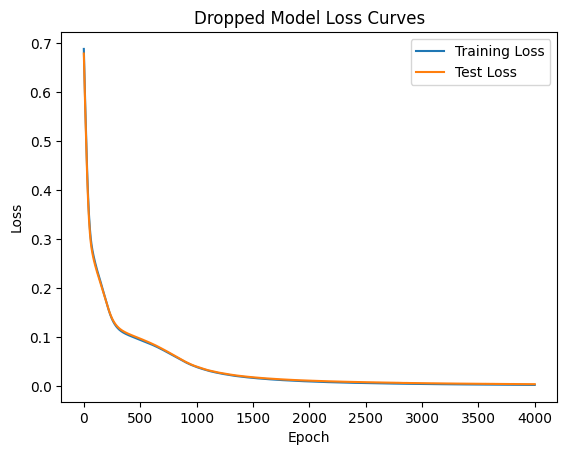

In [5]:
dropped_model = AlarmNet(
    num_features=X_train_dropped.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 64]
    
).to(device)

X_train_dropped_device = torch.tensor(X_train_dropped).float().to(device)
X_test_dropped_device = torch.tensor(X_test_dropped).float().to(device)
Y_train_dropped_device = torch.tensor(Y_train_dropped).float().view(-1, 1).to(device)
Y_test_dropped_device = torch.tensor(Y_test_dropped).float().view(-1, 1).to(device)

dropped_model.train(
    epochs=4000,
    X_train=X_train_dropped_device,
    X_test=X_test_dropped_device,
    Y_train=Y_train_dropped_device,
    Y_test=Y_test_dropped_device,
    alpha=1e-3,
    print_epoch = 500
)
dropped_model.print_results()
AlarmNet.compare_results(dropped_model.get_results(), full_model.get_results())
dropped_model.plot_training("Dropped Model Loss Curves")

## Feature Analysis Results
- We can remove the bottom 8 features and have a model that only loses 0.1% precision, and even less for every other metric
- A 4 feature model is almost perfect
    - These features are:
        - Humidity
        - Raw Ethanol
        - Pressure
        - TVOC
- Note that the Particulate Matter sensor is not included in the 4-feature model.
    - To add redundancy to our model, we can add back the most correlated feature from the PM sensor
    - This feature is PM0.5




In [6]:

# Add back the most correlated PM feature, so that all 4 sensors are used
# PM0.5 is the most correlated PM feature, with index 5
remaining_features_2 = list(remaining_features)
remaining_features_2.append(ranking.index[5])
X_5f = data[remaining_features_2]
X_train_5f, X_test_5f, Y_train_5f, Y_test_5f = train_test_split(X_5f, Y_df, test_size=0.2, random_state=0)



scaler = StandardScaler()
X_train_5f_scaled = scaler.fit_transform(X_train_5f)
X_test_5f_scaled = scaler.transform(X_test_5f)

----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.6985044479 | 0.6392147541 |
----------------------------------------
|   500 |  0.0115998480 | 0.0117754191 |
----------------------------------------
|  1000 |  0.0660767555 | 0.1109553277 |
----------------------------------------
|  1500 |  0.0520891994 | 0.0970609263 |
----------------------------------------
|  2000 |  0.0499802902 | 0.0949731097 |
----------------------------------------
|  2500 |  0.0489524677 | 0.0939934403 |
----------------------------------------
|  2999 |  0.0484523065 | 0.0935083851 |
----------------------------------------
Accuracy: 0.999041992655277
Precision: 0.9987683350128765
Recall: 0.999887904943392
F1: 0.9993278064082456
Confusion_matrix:
[[3594   11]
 [   1 8920]]
Classification_report:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3605
         1.0       

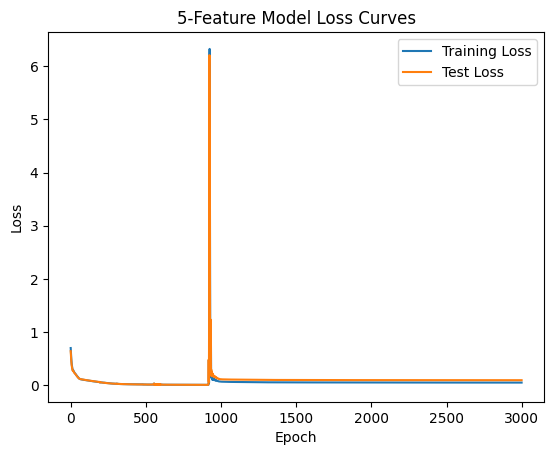

In [7]:

dropped_model_5 = AlarmNet(
    num_features=X_train_5f_scaled.shape[1],  # Update to match the new input dimensions
    activation = nn.ReLU,
    hidden_layers=[64, 32]
    
).to(device)
epochs = 3000
alpha = 1e-2

X_train_5f_device = torch.tensor(X_train_5f_scaled).float().to(device)
X_test_5f_device = torch.tensor(X_test_5f_scaled).float().to(device)
Y_train_5f_device = torch.tensor(Y_train_raw).float().view(-1, 1).to(device)
Y_test_5f_device = torch.tensor(Y_test_raw).float().view(-1, 1).to(device)

dropped_model_5.train(epochs, X_train_5f_device, X_test_5f_device, Y_train_5f_device, Y_test_5f_device, alpha)

dropped_model_5_results = dropped_model_5.get_results()
dropped_model_5.print_results()

AlarmNet.compare_results(dropped_model_5_results, dropped_model.get_results())

dropped_model_5.plot_training("5-Feature Model Loss Curves")


# Outlier Removal
- The curve above has an odd spike in the middle of training. This may be due to the heavily biased distributions of the NC0.5 and TVOC features

array([[<Axes: title={'center': 'Humidity[%]'}>,
        <Axes: title={'center': 'Raw Ethanol'}>],
       [<Axes: title={'center': 'Pressure[hPa]'}>,
        <Axes: title={'center': 'TVOC[ppb]'}>],
       [<Axes: title={'center': 'NC0.5'}>, <Axes: >]], dtype=object)

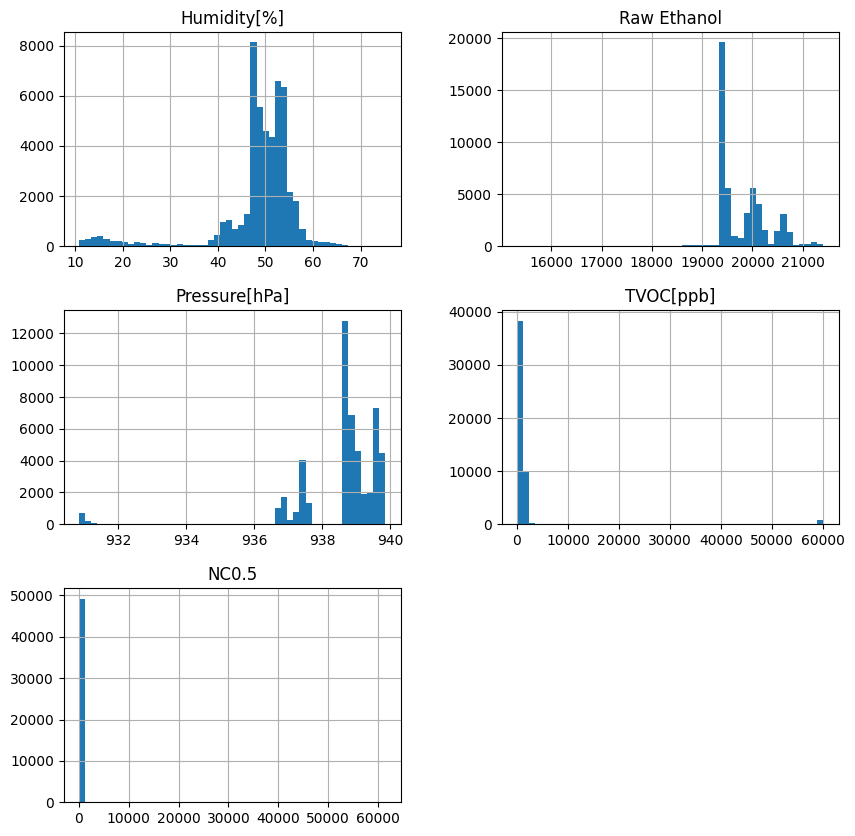

In [8]:
#X_train_5f_scaled, X_test_5f_scaled, Y_train_5f, Y_test_5f = train_test_split(X_5f, Y_df, test_size=0.2, random_state=0)

X_train_5f.hist(
    figsize=(10, 10),
    bins=50
    )

## Outlier Removal
- The majority of the data in the NC0.5 feature lies below 30, and the majority of the data in the TVOC feature lies below 1500
- By removing the data above these thresholds, we can remove the bias from the data and produce a much more even distribution
- However, this filter cannot be applied to the validation data, as the real sensor data will likely follow the original skewed distribution

Data reduction: 5.79%


array([[<Axes: title={'center': 'Humidity[%]'}>,
        <Axes: title={'center': 'Raw Ethanol'}>],
       [<Axes: title={'center': 'Pressure[hPa]'}>,
        <Axes: title={'center': 'TVOC[ppb]'}>],
       [<Axes: title={'center': 'NC0.5'}>, <Axes: >]], dtype=object)

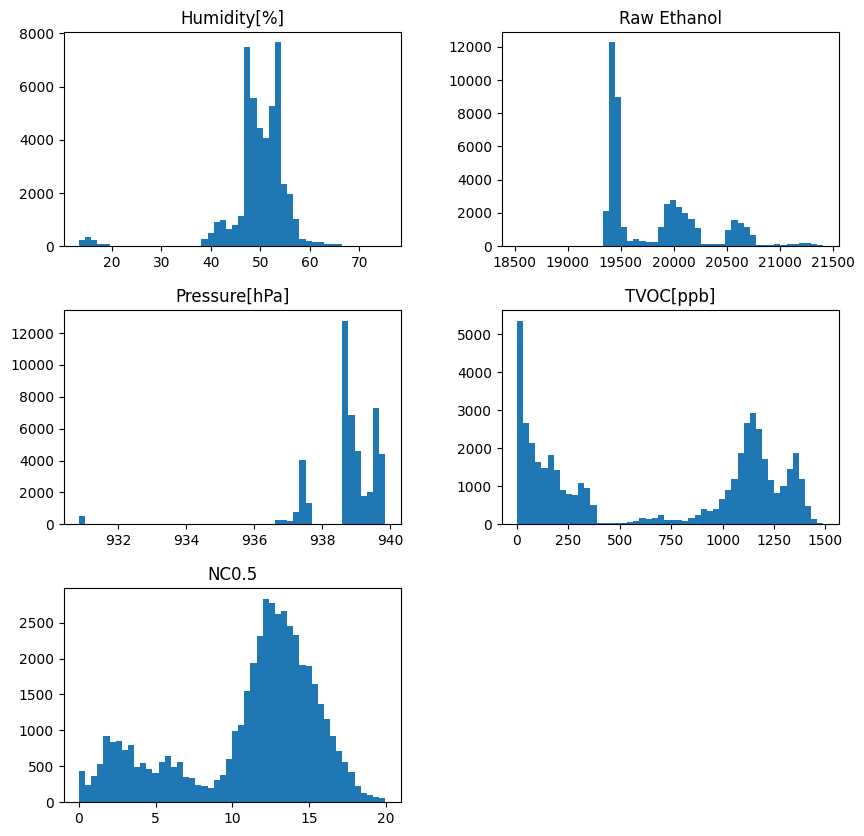

In [9]:
import matplotlib.pyplot as plt

TVOC_threshold = 1500
NC0_5_threshold = 20

X_train_outlier, X_test_outlier, Y_train_outlier, Y_test_outlier = train_test_split(X_5f, Y_df, test_size=0.2, random_state=0)

X_train_outlier =  X_train_outlier[(X_train_outlier['TVOC[ppb]'] < TVOC_threshold) & (X_train_outlier['NC0.5'] < NC0_5_threshold)]
Y_train_outlier = Y_train_outlier[X_train_outlier.index]

data_reduction = 100*(1 - X_train_outlier.shape[0] / X_train_5f_scaled.shape[0])
print(f'Data reduction: {data_reduction:.2f}%')

X_train_outlier.hist(
    figsize=(10, 10),
    grid=False,
    bins=50
)

## Improved Distribution
- The training data is much more evenly distributed.
- However, it does not make sense to apply this filter to the validation data, as the real sensor values will follow the original distribution

----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.7120997310 | 0.7095080018 |
----------------------------------------
|   500 |  0.1854066253 | 0.5124326348 |
----------------------------------------
|  1000 |  0.1076950133 | 2.2609353065 |
----------------------------------------
|  1500 |  0.0868244767 | 2.8968970776 |
----------------------------------------
|  2000 |  0.0601450652 | 3.4452738762 |
----------------------------------------
|  2500 |  0.0336388126 | 3.7247207165 |
----------------------------------------
|  2999 |  0.0186653286 | 3.8090333939 |
----------------------------------------
Accuracy: 0.9547341529618394
Precision: 0.9432300509337861
Recall: 0.9964129581885439
F1: 0.9690923957481603
Confusion_matrix:
[[3070  535]
 [  32 8889]]
Classification_report:               precision    recall  f1-score   support

         0.0       0.99      0.85      0.92      3605
         1.0     

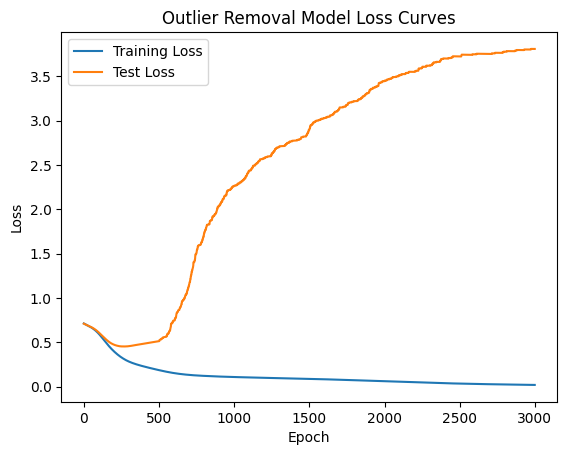

In [10]:
#remove all rows where TVOC>3000 or NC0.5>4000

scaler = StandardScaler()
scaler.fit(X_train_5f)
X_train_outlier_scaled = scaler.transform(X_train_outlier)
X_test_outlier_scaled = scaler.transform(X_test_5f)


X_train_outlier_device = torch.tensor(X_train_outlier_scaled).float().to(device)
X_test_outlier_device = torch.tensor(X_test_outlier_scaled).float().to(device)
Y_train_outlier_device = torch.tensor(Y_train_outlier.values).float().view(-1, 1).to(device)
Y_test_outlier_device = torch.tensor(Y_test_5f.values).float().view(-1, 1).to(device)

outlier_model = AlarmNet(
    num_features=X_train_outlier.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 128, 64]
).to(device)

outlier_model.train(
    epochs=3000,
    X_train=X_train_outlier_device,
    X_test=X_test_outlier_device,
    Y_train=Y_train_outlier_device,
    Y_test=Y_test_outlier_device,
    alpha=1e-4,
    print_epoch = 500
)
outlier_model.print_results()
AlarmNet.compare_results(outlier_model.get_results(), dropped_model_5_results)
outlier_model.plot_training("Outlier Removal Model Loss Curves")


# Imputation
- The training and validation datasets have completely different distributions
    - This causes overfitting
- Solution: Imputation
    - Replace each value above the threshold with the median of the feature
    - Chose median because it is a better measure of center than mean for skewed distributions


In [11]:
class Imputer:
    def __init__(self, thresholds: list[float]):
        self.thresholds = thresholds
    def fit(self, data: pd.DataFrame):
        self.replacements = data.median()

    def transform(self, data: pd.DataFrame) -> pd.DataFrame:
        for i, column in enumerate(data.columns):
            data[column] = data[column].apply(lambda x: self.replacements.iloc[i] if (x > self.thresholds[i] or np.isnan(x)) else x)
        return data
    def fit_transform(self, data: pd.DataFrame) -> pd.DataFrame:
        self.fit(data)
        return self.transform(data)

(50104, 5)


array([[<Axes: title={'center': 'Humidity[%]'}>,
        <Axes: title={'center': 'Raw Ethanol'}>],
       [<Axes: title={'center': 'Pressure[hPa]'}>,
        <Axes: title={'center': 'TVOC[ppb]'}>],
       [<Axes: title={'center': 'NC0.5'}>, <Axes: >]], dtype=object)

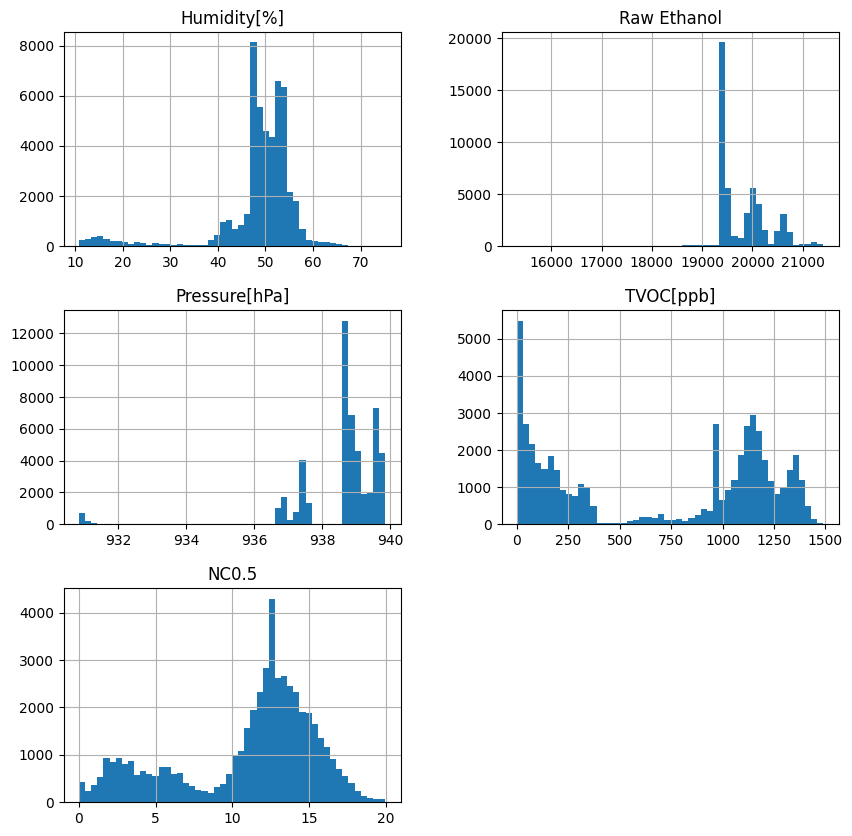

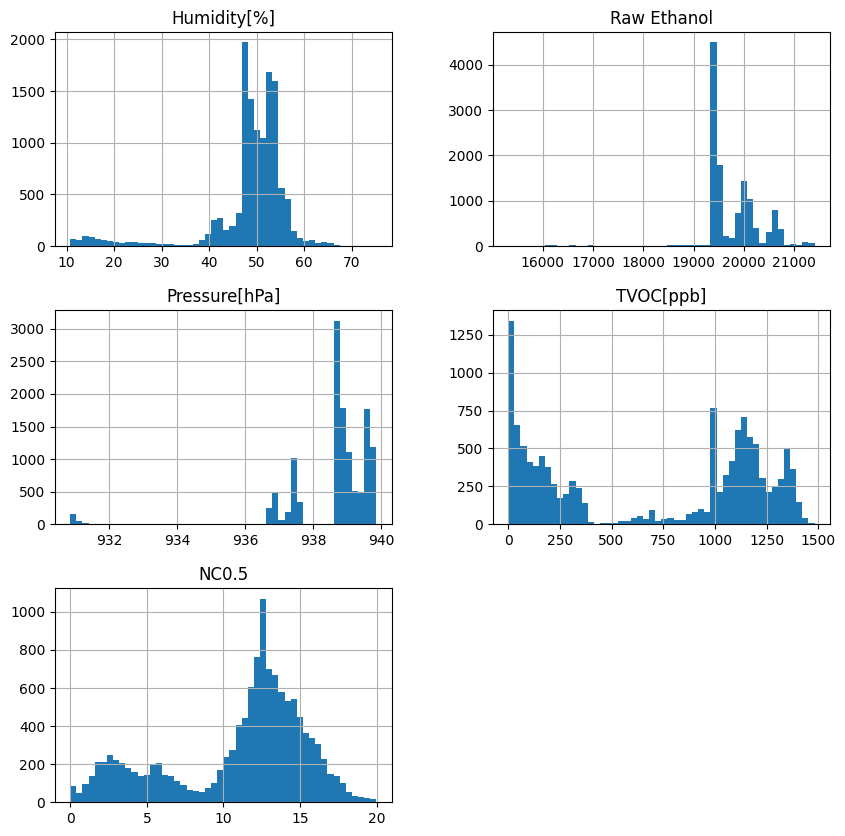

In [12]:
X_train_imputed, X_test_imputed, Y_train_imputed, Y_test_imputed = train_test_split(X_5f, Y_df.values, test_size=0.2, random_state=0)

thresholds = [70000, 70000, 70000, 1500, 20]
imputer = Imputer(thresholds)

X_train_imputed = imputer.fit_transform(X_train_imputed)
X_test_imputed = imputer.transform(X_test_imputed)

print(X_train_imputed.shape)
X_train_imputed.hist(
    figsize=(10, 10),
    bins=50
)
X_test_imputed.hist(
    figsize=(10, 10),
    bins=50
)
# print(X_train_5f.shape)
# print(X_train_imputed.shape)
# print(Y_train_imputed.shape)

----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.6822211146 | 0.6228777170 |
----------------------------------------
|   500 |  0.0010933348 | 0.0016873752 |
----------------------------------------
|  1000 |  0.0007070738 | 0.0010464260 |
----------------------------------------
|  1500 |  0.0004483495 | 0.0007000870 |
----------------------------------------
|  2000 |  0.0109527754 | 0.0254866928 |
----------------------------------------
|  2500 |  0.0107084429 | 0.0251187831 |
----------------------------------------
|  2999 |  0.0105767082 | 0.0249435138 |
----------------------------------------
Accuracy: 0.9994411623822449
Precision: 0.9993278064082456
Recall: 0.999887904943392
F1: 0.9996077772174595
Confusion_matrix:
[[3599    6]
 [   1 8920]]
Classification_report:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3605
         1.0      

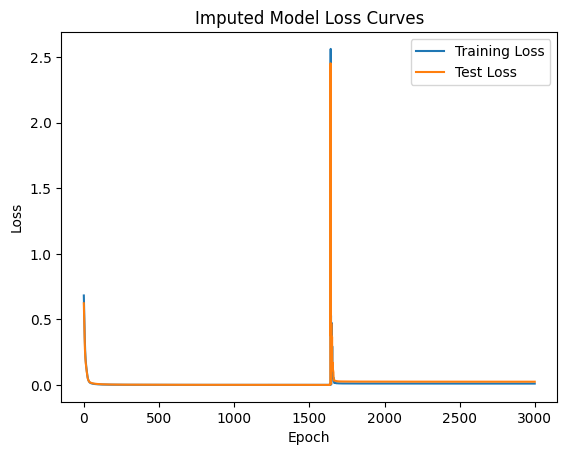

In [13]:

X_train_imputed_device = torch.tensor(scaler.fit_transform(X_train_imputed)).float().to(device)
X_test_imputed_device = torch.tensor(scaler.transform(X_test_imputed)).float().to(device)
Y_train_imputed_device = torch.tensor(Y_train_imputed).float().view(-1, 1).to(device)
Y_test_imputed_device = torch.tensor(Y_test_imputed).float().view(-1, 1).to(device)

imputed_model = AlarmNet(
    num_features=X_train_imputed.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 32]
).to(device)

imputed_model.train(
    epochs=3000,
    X_train=X_train_imputed_device,
    X_test=X_test_imputed_device,
    Y_train=Y_train_imputed_device,
    Y_test=Y_test_imputed_device,
    alpha=1e-2,
    print_epoch = 500
)

imputed_model.print_results()
AlarmNet.compare_results(imputed_model.get_results(), dropped_model_5_results)
imputed_model.plot_training("Imputed Model Loss Curves")



# Error Handling
- The 12 initial features came from 4 sensors
    - Temp/Humidity
    - Pressure
    - Volatile Organic Compounds (CO2, Ethanol, H2, TVOC)
    - Particulate Matter (PM1, PM2.5, NC0.5, NC1, NC2.5)
- 3 of these sensors are redundant, with the exception being the PM sensor
    - This means that the features related to the PM sensor are twice as likely to be missing
- We can simulate a real world scenario by introducing error according to this distribution

In [14]:
import random

# Introduce sensor errors

VOC_features = [
    'TVOC[ppb]',
    'eCO2[ppm]',
    'Raw H2',
    'Raw Ethanol'
]

PM_features = [
    'PM1.0',
    'PM2.5',
    'NC0.5',
    'NC1.0',
    'NC2.5'
]

th_features = [
    'Temperature[C]',
    'Humidity[%]'
]
pressure_features = [
    'Pressure[hPa]'
]

# For each measurement, each sensor has this chance of introducing an error
error_chance = 0.2

# The PM sensor is twice as likely to fail due to lack of redundancy
chances = [error_chance, error_chance*2, error_chance, error_chance]
sensors = [VOC_features, PM_features, th_features, pressure_features]


X_error_np = X_5f.values.copy()
for i, datapoint in enumerate(X_error_np):
    errored_features = []
    for j, sensor in enumerate(sensors):
        sensor_error = random.random() < chances[j]
        if sensor_error:
            errored_features.extend(sensor)
    errored_features = [feature for feature in errored_features if feature in X_5f.columns]
    if errored_features:
        for feature in errored_features:
            X_error_np[i][X_5f.columns.get_loc(feature)] = np.nan
        # print(i, X_error_np[i])

X_train_error, X_test_error, Y_train_error, Y_test_error = train_test_split(X_error_np, Y_df.values, test_size=0.2, random_state=0)

In [15]:
imputer_2 = Imputer(thresholds)
X_train_error_imputed = imputer_2.fit_transform(pd.DataFrame(X_train_error, columns=X_5f.columns))
X_test_error_imputed = imputer_2.transform(pd.DataFrame(X_test_error, columns=X_5f.columns))
scaler = StandardScaler()
X_train_error_scaled = scaler.fit_transform(X_train_error_imputed)
X_test_error_scaled = scaler.transform(X_test_error_imputed)


In [16]:

imputed_error_model = AlarmNet(
    num_features=X_train_error_scaled.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 32]
).to(device)

X_train_error_device = torch.tensor(X_train_error_scaled).float().to(device)
X_test_error_device = torch.tensor(X_test_error_scaled).float().to(device)
Y_train_error_device = torch.tensor(Y_train_error).float().view(-1, 1).to(device)
Y_test_error_device = torch.tensor(Y_test_error).float().view(-1, 1).to(device)

imputed_error_model.train(
    epochs=3000,
    X_train=X_train_error_device,
    X_test=X_test_error_device,
    Y_train=Y_train_error_device,
    Y_test=Y_test_error_device,
    alpha=1e-2,
    print_epoch = 500
)

imputed_error_model.print_results()
AlarmNet.compare_results(imputed_error_model.get_results(), imputed_model.get_results())


----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.7168553472 | 0.6630414128 |
----------------------------------------
|   500 |  0.0355669186 | 0.0429005511 |
----------------------------------------
|  1000 |  0.0304910131 | 0.0427564569 |
----------------------------------------
|  1500 |  0.0290309489 | 0.0501789860 |
----------------------------------------
|  2000 |  0.0282739550 | 0.0567290559 |
----------------------------------------
|  2500 |  0.0566105545 | 0.1039112508 |
----------------------------------------
|  2999 |  0.0556031018 | 0.1032341868 |
----------------------------------------
Accuracy: 0.9861887274469104
Precision: 0.9861080240053345
Recall: 0.9946194372828159
F1: 0.9903454433841175
Confusion_matrix:
[[3480  125]
 [  48 8873]]
Classification_report:               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      3605
         1.0     

## Error Modes
- Current features:
    - Humidity
    - Raw Ethanol
    - Pressure
    - TVOC
    - NC0.5
- Sensors:
    - Humidity
    - Pressure
    - Raw Ethanol/TVOC
    - NC0.5
- The model should be able to handle missing data in the case where at most 3 sensors have failed, because 4 failed sensors means no data
    - 1 failed sensor = 4c1 = 4
    - 2 failed sensors = 4c2 = 6
    - 3 failed sensors = 4c3 = 4
    - Total = 14
## Ensemble Training
- We can train 14 models that can predict the missing data for each error mode
- In the case of error, we select the model that corresponds to the error mode and use it to predict the missing data
- Then use the main model to predict the target
### Indexing Ensemble
- Columns should be rearranged according to sensors
    - Humidity, Pressure, NC0.5, Ethanol, TVOC, 
- The error mode can be represented as a 4-bit value
    - 0b0000 = No error
    - 0b0001 = Ethanol/TVOC Error
    - 0b0010 = NC0.5 Error
    - 0b0100 = Pressure error
    - 0b1000 = Humidity error
- A 5-bit value can represent which features are missing
    - 0b00000 = No error
    - 0b00011 = Ethanol/TVOC Error
    - 0b00100 = NC0.5 Error
    - 0b01000 = Pressure error
    - 0b10000 = Humidity error
- We can convert from the 5-bit value to the 4-bit value with a simple shift right operation

### Model Table
- Store the models with an array
- The index of the model is the error mode
- Model 15 will always predict 1, because if all sensors have failed the worst should be assumed for safety
- Model 0 will be the standard model trained on a full dataset
- The rest of the arrays will be trained on the data with the corresponding error mode
### New Model Type
- A new model class will be created that will predict the missing values, construct the repaired dataset, call the standard model, and return the result
### Ensemble Class
- This new class will hold the model table and the standard model
- It will be responsible for constructing the model address, calling the correct model, and returning the result



    

